# Machine Learning Exercise 1

In [0]:
import sys
from io import StringIO

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import SGDRegressor, SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, max_error, r2_score, mean_absolute_error, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler

In [0]:
url = 'https://raw.githubusercontent.com/MSc-in-Data-Science/class_material/master/semester_1/Machine_Learning/datasets/bike-sharing-dataset/day.csv'
day_data = pd.read_csv(url)

In [341]:
day_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [0]:
features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
day_data = day_data[features]

### Αρχική αφαίρεση
Με μία πρώτη ματιά στα δεδομένα μας βλέπουμε ότι τα χαρακτηριστικά instant και dteday δεν προσφέρουν καμία πληροφορία αφού είναι συνεχώς αυξανόμενα για κάθε instance και επομένως πρέπει να αφαιρεθούν

In [343]:
day_data.dtypes

season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

### Παρατήρηση πάνω στον τύπο των δεδομένων μας
Βλέπουμε ότι τα χαρακτηριστικά μας αποτελούνται από αριθμητικά αλλά και κατηγορηματικά, που έχουν μετατραπεί σε αριθμούς με one hot encode

In [344]:
day_data.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


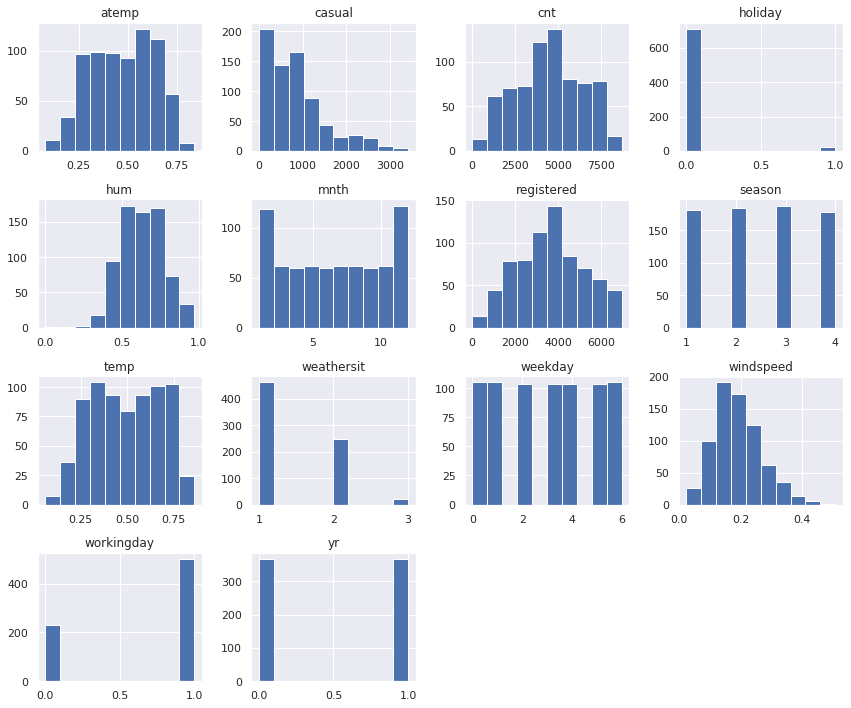

In [367]:
day_data.hist(figsize=(12,10))
plt.tight_layout()

### Κατανομή των δεδομένων
Παρατηρούμε ότι τα περισσότερα αριθμητικά δεδομένα μας ακολουθούν μια κανονική κατανομή. Μερικά όπως το hum και το windspeed παρουσιάζουν skew

[Text(0.5, 1.0, 'Κατανομή των χρηστών ανά χρόνο')]

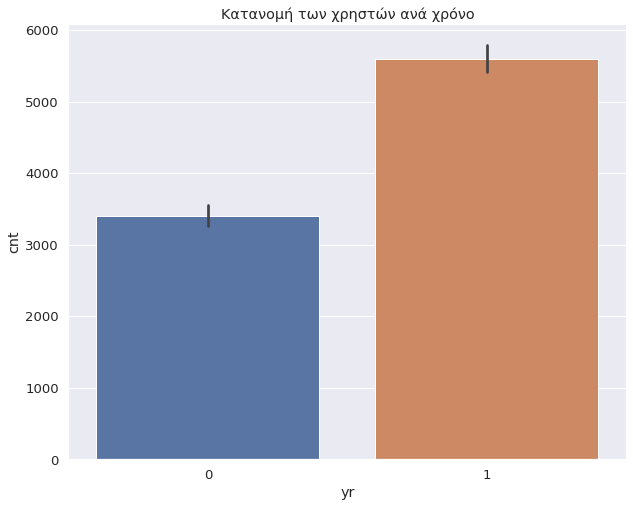

In [346]:
fig,ax = plt.subplots(figsize=(10,8))
sns.barplot(data=day_data[['yr','cnt']],x='yr',y='cnt',ax=ax)
ax.set(title="Κατανομή των χρηστών ανά χρόνο")

### Απόφαση για το χρόνο
Από το γράφημα παρατηρούμε ότι οι χρήστες κατά το δεύτερο χρόνο είναι σίγουρα αυξημένοι, αλλά σαν απόφαση μοντελοποίησης παίρνουμε το δεδομένο ότι θέλουμε να βρούμε αποτελέσματα για το πλαίσιο αυτών των χρόνων. Επομένως θα κρατήσουμε το χαρακτηριστικό αυτό.

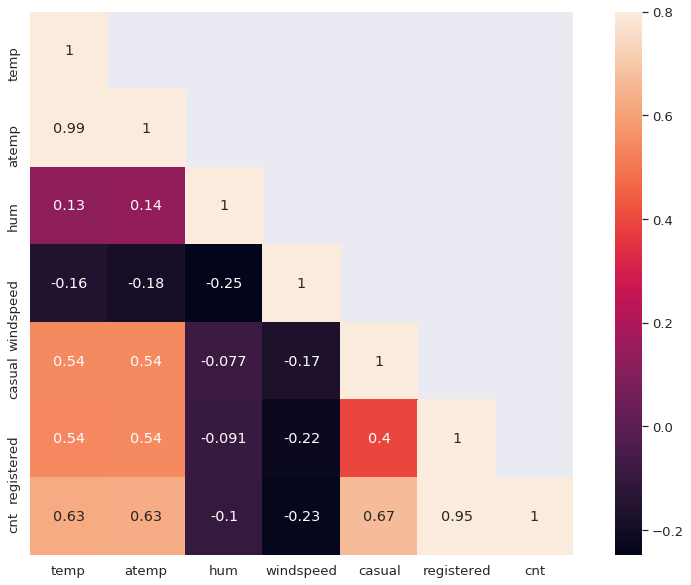

In [347]:
numeric_features = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
correlations = day_data[numeric_features].corr()
mask = np.array(correlations)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots()
fig.set_size_inches(15,10)
sns.set(font_scale=1.2)
sns.heatmap(correlations, 
            mask=mask,
            vmax=.8, 
            square=True,
            annot=True,
            ax=ax)

### Παρατηρήσεις στα αριθμητικά χαρακτηριστικά
1) Παρατηρώντας τα χαρακτηριστικά casual και registered, εκτός του ότι έχουν μεγάλο correlation μεταξύ τους αλλά και με το cnt, είναι εμφανές ότι πρέπει να αφαιρεθούν γιατί το άθροισμά τους μας δίνει το ίδιο το cnt που στη συνέχεια θα προσπαθήσουμε να προβλέψουμε. Από τη στιγμή που καθοδηγούν με τέτοιο τρόπο το μοντέλο μας, τότε θεωρώ ότι πρέπει να αφαιρεθούν.
2) Τα features temp και atemp είναι πλήρως correlated μεταξύ τους, άρα μπορούμε να κρατήσουμε μόνο το feature temp, αφού μας δίνουν ακριβώς την ίδια πληροφορία και αν μείνουν και τα δύο, τότε καθοδηγούν επίσης το αποτέλεσμα, αφού θα είναι σα να έχουμε πάρει το ίδιο feature δύο φορές.

In [0]:
features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed']

## a) Classification

In [0]:
def get_best_tree_depth():
    depth = 0
    best_score = 0
    for i in range(3,15):
        clf = DecisionTreeClassifier(max_depth=i, criterion='entropy', random_state=1)
        scores = cross_val_score(clf, X, y, cv=5, error_score='f1')
        if scores.mean() > best_score:
            best_score = scores.mean()
            depth = i
    return depth

def print_errors(y_original, y_pred, dataset=''):
    print(dataset + " Decision Tree F1 score: {:.2f}".format(f1_score(y_original, y_pred, average='micro')))
    print(dataset + " Decision Tree Accuracy score: {:.2f}\n".format(accuracy_score(y_original, y_pred)))

In [0]:
y = pd.cut(day_data.cnt, 4, labels=[1, 2, 3, 4])
X = day_data[features]

Σπάμε τα labels μας σε 4 buckets και διαχωρίζουμε τα features στο X

In [351]:
best_tree_depth = get_best_tree_depth()
print('Creating Tree for max depth', best_tree_depth, '\n')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
best_tree_model = DecisionTreeClassifier(max_depth=best_tree_depth, criterion='entropy', random_state=1)
best_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

Βρίσκουμε το depth που μας δίνει καλύτερο accuracy και κάνουμε train το μοντέλο μας

In [0]:
y_pred = best_tree_model.predict(X_test)
print_errors(y_test, y_pred, dataset='Test')

y_pred = best_tree_model.predict(X_train)
print_errors(y_train, y_pred, dataset='Train')

print('Features rated by importance')
print(dict(zip(features, best_tree_model.feature_importances_)))

### Παρατηρήσεις
Από τα στατιστικά παρατηρούμε ότι το δέντρο μας δεν έχει κάνει overfit, όπως επίσης ότι τα 2 prominent features είναι το temp και το yr

## b) Linear Regression

In [0]:
y = day_data.cnt
features = ['temp', 'hum', 'windspeed']
X = day_data[features]

Με βάση το filtering των features που κάναμε πριν και με το ζητούμενο του ερωτήματος να κρατήσουμε μόνο αριθμητικά χαρακτηριστικά, καταλήγουμε στο ότι το feature set μας θα αποτελείται από αυτά τα 3 χαρακτηριστικά, μιας και τα υπόλοιπα είναι κατηγορηματικά.

In [0]:
def print_errors(y_pred, y_test):
    print("R2 Score: {:.2f}".format(r2_score(y_test, y_pred)))
    print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred)))
    print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_test, y_pred)))
    print("Max Error: {:.2f}".format(max_error(y_test, y_pred)))


def normalize_data(train_data, test_data):
    normalizer = Normalizer().fit(train_data)
    train_normalized = normalizer.transform(train_data)
    test_normalized = normalizer.transform(test_data)
    return train_normalized, test_normalized

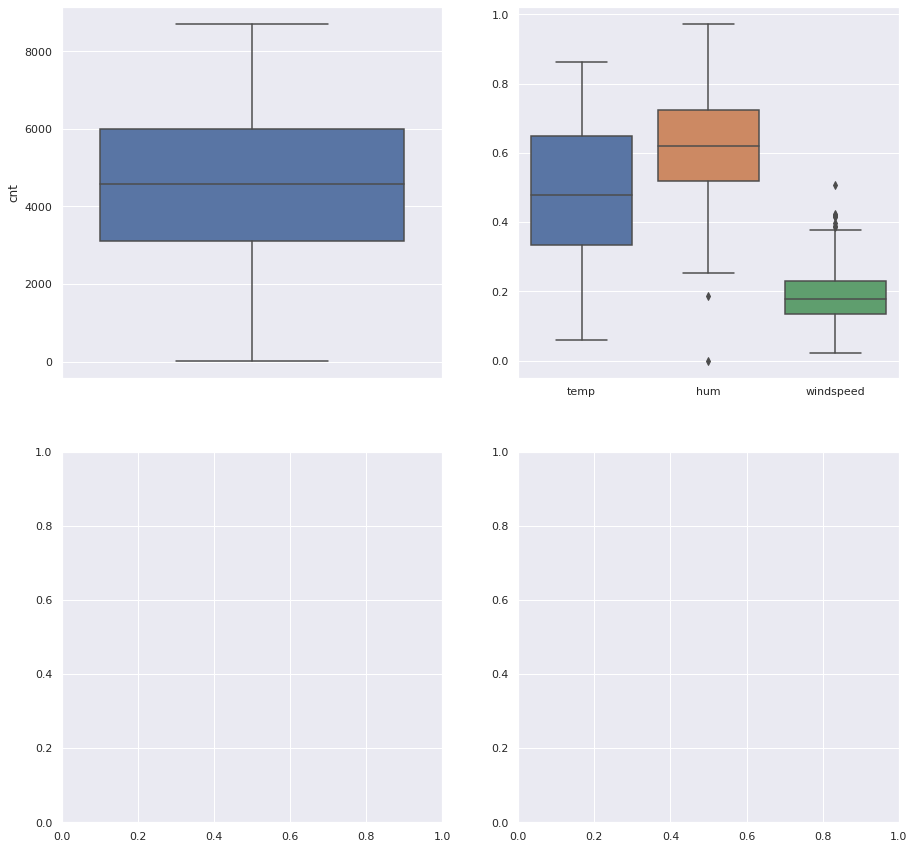

In [355]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

train = X_train.copy()
train['cnt'] = y_train
# fig,ax = plt.subplots()
# sns.boxplot(data=train[['cnt','temp']],x='temp',y='cnt',ax=ax)
# ax.set(title="Checking for outliners in day hours")
sns.set(font_scale=1.0)
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15, 15)
sns.boxplot(data=train, y="cnt", orient="v", ax=axes[0][0])
sns.boxplot(data=train[features], orient="v", ax=axes[0][1])
# sns.boxplot(data=train, y="cnt", x="windspeed", orient="v", ax=axes[1][0])
# sns.boxplot(data=train, y=train['cnt'], x=train[features], orient="v", ax=axes[1][1])

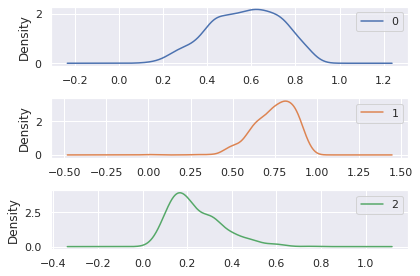

In [356]:
X_train, X_test = normalize_data(X_train, X_test)
pd.DataFrame(data=X_train).plot(kind='density', subplots=True, layout=(3,1), sharex=False)
plt.tight_layout()

### Normalizing
Κάνουμε nomalize τα features μας προκειμένου να ακολουθούν όλα κανονική κατανομή

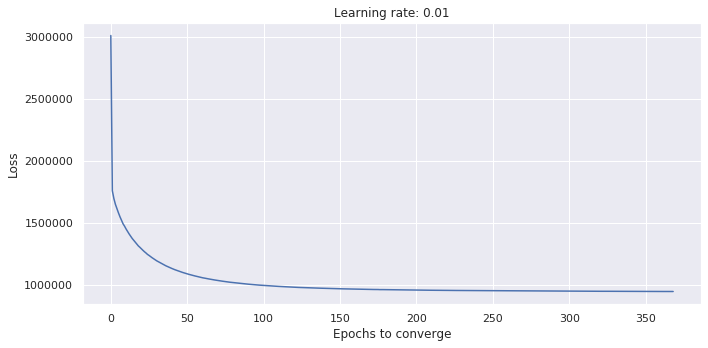

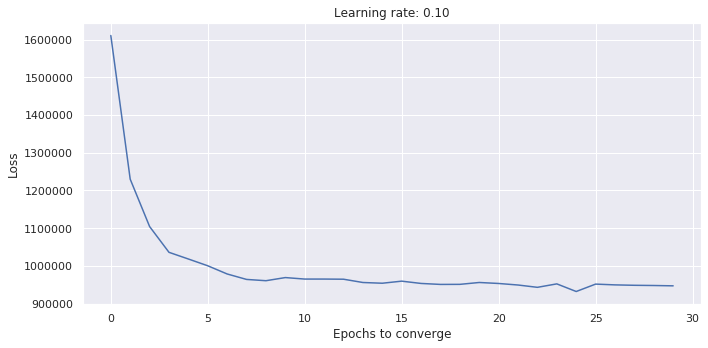

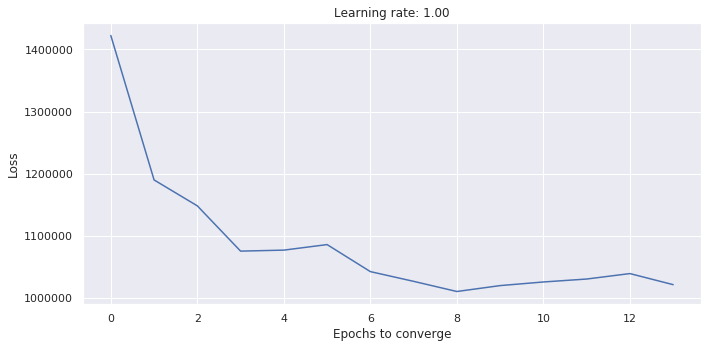

In [357]:
learning_rates = [0.01, 0.1, 1]

for i in range(3):
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()
    sgd_model = SGDRegressor(eta0=learning_rates[i], verbose=1, random_state=7)
    clf = sgd_model.fit(X_train, y_train)
    sys.stdout = old_stdout
    loss_history = mystdout.getvalue()
    loss_list = []
    for line in loss_history.split('\n'):
        if len(line.split("loss: ")) == 1:
            continue
        loss_list.append(float(line.split("loss: ")[-1]))
    plt.figure(figsize=(10, 5))
    plt.xlabel("Epochs to converge")
    plt.ylabel("Loss")
    plt.title("Learning rate: {:.2f}".format(learning_rates[i]))
    plt.plot(np.arange(len(loss_list)), loss_list)
    plt.tight_layout()
    y_pred = clf.predict(X_test)
    print("Score for learning rate: {:.2f}".format(learning_rates[i]))
    print_errors(y_pred, y_test)
    print("")

### Παρατηρήσεις πάνω στο training
Κάνοντας train το μοντέλο μας για 3 διαφορετικά learning rates, από το plotting και από τα αποτελέσματα των μετρικών καταλήγουμε στα εξής συμπεράσματα:
Επιλέγουμε ως learning rate to 0.1 γιατί μας δίνει περίπου το ίδιο accuracy με το 0.01 αλλά κάνει converge πολύ πιο γρήγορα (σε 30 epochs σε σχέση με το 0.01 που θέλει 350), επομένως με βάση το occam's razor principle θα διαλέξουμε το μοντέλο που είναι πιο 'μικρό' και γρήγορο.
Το leaning rate 1 αν και κάνει converge ακόμα γρηγορότερα, μας δίνει χειρότερο accucy και παρατηρούμε από το διάγραμμα πως το rate είναι αρκετά μεγάλο ώστε να περνάει το ελάχιστο αρκετές φορές

In [0]:
sgd_model = SGDRegressor(eta0=0.1, verbose=1, random_state=7)
clf = sgd_model.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print_errors(y_pred, y_test)

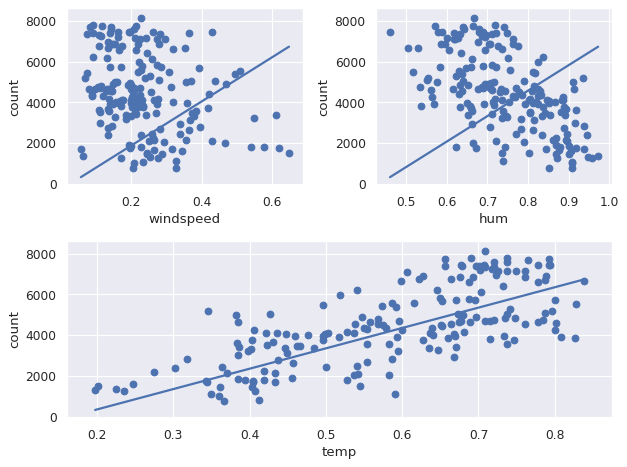

In [359]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(212)
plt.plot([X_test[:,0].min(), X_test[:,0].max()], [y_pred.min(), y_pred.max()], lw=2)
plt.scatter(X_test[:,0], np.array(y_test))
plt.xlabel('temp')
plt.ylabel('count')


plt.subplot(222)
plt.plot([X_test[:,1].min(), X_test[:,1].max()], [y_pred.min(), y_pred.max()], lw=2)
plt.scatter(X_test[:, 1], np.array(y_test))
plt.xlabel('hum')
plt.ylabel('count')

plt.subplot(221)
plt.plot([X_test[:,2].min(), X_test[:,2].max()], [y_pred.min(), y_pred.max()], lw=2)
plt.scatter(X_test[:, 2], np.array(y_test))
plt.xlabel('windspeed')
plt.ylabel('count')
plt.tight_layout()

Κάνοντας plot τη γραμμή του μοντέλου μας σε σχέση με κάθε ένα από τα 3 χαρακτηριστικά, βλέπουμε το variance που υπάρχει στα χαρακτηριστικά μας και το λόγο που δεν έχουμε πολύ υψηλό accuracy

In [0]:
X1 = day_data.temp[4:5].values
y1 = day_data.cnt[4:5].values

Παίρνουμε μόνο 1 instance με μόνο 1 feature (το most prominent)

In [0]:
prediction_errors = []
n_iter = 30

old_stdout = sys.stdout
sys.stdout = mystdout = StringIO()

sgd_model = SGDRegressor(max_iter=1, eta0=2, learning_rate='constant', random_state=2, verbose=1)
for n in range(n_iter):
    sgd_model.partial_fit(X1.reshape(-1, 1), y1)
    y_pred = sgd_model.predict(X1.reshape(-1, 1))
    prediction_errors.append(np.sum(y1-y_pred))

sys.stdout = old_stdout
loss_history = mystdout.getvalue()
loss_list = []
for line in loss_history.split('\n'):
    if len(line.split("loss: ")) == 1:
        continue
    loss_list.append(float(line.split("loss: ")[-1]))

Κάνουμε partial fit το μοντέλο μας έτσι ώστε να μην ξεκινάνε τα βάρη με τυχαίους αριθμούς, θέτουμε learning rate 2 και κάνουμε 30 iterations προκειμένου να συλλέξουμε αρκετά losses και errors για να κάνουμε plot

Text(0, 0.5, 'Loss')

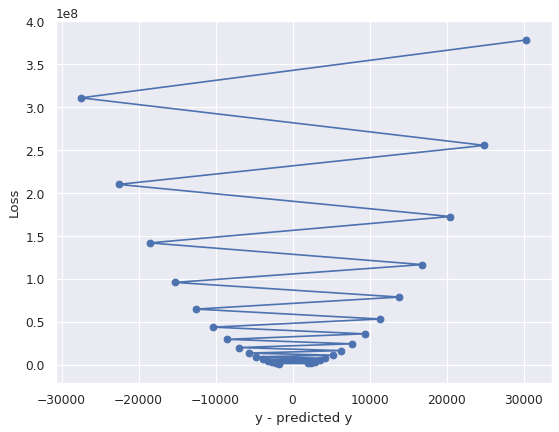

In [362]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(prediction_errors, loss_list)
plt.scatter(prediction_errors, loss_list)
plt.xlabel("y - predicted y")
plt.ylabel("Loss")

## c) Logistic Regression

In [0]:
y = pd.cut(day_data.cnt, 2, labels=[0, 1])
features = ['temp', 'hum', 'windspeed']
X = day_data[features]

X1 = X.temp[4:5].values
y1 = y[4:5].values

print(X1)
print(y1)

In [0]:
clf = LogisticRegression(solver='liblinear', multi_class='auto')

results = cross_val_score(clf, X, y, cv=10)
print("Accuracy: %.2f" % results.mean())

In [0]:
prediction_errors = []
n_iter = 30


old_stdout = sys.stdout
sys.stdout = mystdout = StringIO()

sgd_clf = SGDClassifier(loss="log", learning_rate='constant', eta0=2, penalty=None, max_iter=1,
                     average=False, random_state=1, verbose=1)

for epoch in range(n_iter):
    model = sgd_clf.partial_fit(X1.reshape(-1, 1), y1, classes=[0, 1])
    y_pred = model.predict(X1.reshape(-1, 1))
    p = model.decision_function(X1.reshape(-1, 1))
    c  = (1 - np.mean(y_pred == y1))
    prediction_errors.append(p)

sys.stdout = old_stdout
loss_history = mystdout.getvalue()
loss_list  = []

for line in loss_history.split('\n'):
    if(len(line.split("loss: ")) == 1):
        continue
    loss_list.append(float(line.split("loss: ")[-1]))

Text(0, 0.5, 'Loss')

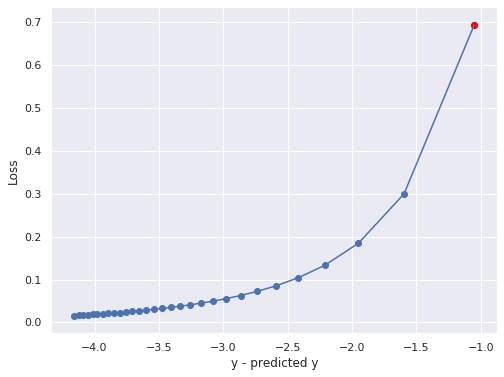

In [366]:
plt.figure(figsize=(8, 6))
plt.plot(prediction_errors, loss_list)
plt.scatter(prediction_errors, loss_list)
plt.scatter(prediction_errors[:1], loss_list[:1], color='red')
plt.xlabel("y - predicted y")
plt.ylabel("Loss")